In [1]:
import numpy as np
from fenics import *
import matplotlib.pyplot as plt

In [2]:
def GRF2d(Nx, Ny, alpha):
    # define wavenumber and coefficients
    kx = np.fft.fftfreq(Nx,1/Nx)  # wavenumbers
    ky = np.fft.rfftfreq(Ny,1/Ny) # wavenumbers
    Kx,Ky = np.meshgrid(kx,ky)    # k = (kx,ky) wavevector in 2d
    K = np.sqrt(Kx**2+Ky**2).T    # wavenumber magnitude |k|

    #
    lmbda = (K+1)**(-alpha)    # decay parameters
    eta = (
        np.random.randn(*K.shape) + 1j*np.random.randn(*K.shape)
    ) # random coefficients

    # Fourier coefficients of u
    uhat = lmbda*eta

    # transform back via inverse FT
    u = np.fft.irfft2(uhat, norm='forward')

    return u

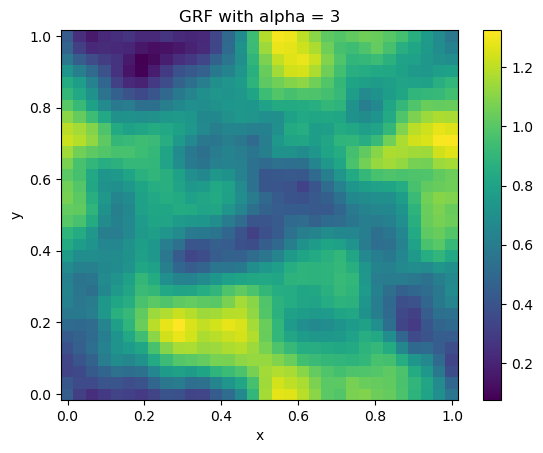

In [35]:
# generate a few 2d fields
N = 32 # number of grid points
x = np.linspace(0,1,N)
X,Y = np.meshgrid(x,x)
alpha = 3
u = GRF2d(N,N,alpha) # generate random field

# plot
plt.figure()
plt.pcolor(X,Y,u)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'GRF with alpha = {alpha}')
plt.show()

In [36]:
# Define mesh and function space
mesh = UnitSquareMesh(N, N) 
V = FunctionSpace(mesh, "P", 1) 

D = Function(V)
# Define the subdomain class
class GridSubDomain(SubDomain):
    def __init__(self, i, j, nx, ny, **kwargs):
        super().__init__(**kwargs)
        self.i = i
        self.j = j
        self.nx = nx
        self.ny = ny
        self.dx = 1.0 / nx
        self.dy = 1.0 / ny

    def inside(self, x, on_boundary):
        x0, x1 = self.i * self.dx, (self.i + 1) * self.dx
        y0, y1 = self.j * self.dy, (self.j + 1) * self.dy
        return x0 <= x[0] <= x1 and y0 <= x[1] <= y1

# Create a MeshFunction to mark the subdomains
subdomains = MeshFunction("size_t", mesh, mesh.topology().dim(), 0)

# Mark each subdomain with a unique ID
for i in range(N):
    for j in range(N):
        subdomain = GridSubDomain(i, j, N, N)
        subdomain.mark(subdomains, i * N + j)

# Define unique material properties for each subdomain
D_values = u
D_value = u.flatten()
D_array = D.vector().get_local()
subdomain_markers = subdomains.array()

# Assign material properties
for i in range(len(D_array)):
    D_array[i] = D_value[subdomain_markers[i]]

D.vector().set_local(D_array)
D.vector().apply("insert")

# The initial condition
parameter = 10
x0, y0 = 0.5,0.5  # Center of the initial condition in the unit square
magnitude = 1
initial_condition = Expression("magnitude*(1-exp(-1/((parameter*parameter*(x[0]-x0)*(x[0]-x0)+parameter*parameter*(x[1]-y0)*(x[1]-y0)))))", 
                                  degree=2, magnitude=magnitude, parameter=parameter, x0=x0, y0=y0, domain=mesh)


# Discretize the initial condition
u_old = interpolate(initial_condition, V)
# Define variational problem
u_trial = TrialFunction(V)
v_test = TestFunction(V)
# Time-stepping length
time_step_length = 0.001
# Time-stepping loop
n_time_steps = 100

# Weak form
weak_form = (u_trial * v_test * dx + D * time_step_length * inner(grad(u_trial), grad(v_test)) * dx) - (u_old * v_test * dx)

# Assemble the system
a = lhs(weak_form)
L = rhs(weak_form)

# Solution function for each timestep
u_solution = Function(V)
# Set up file for saving results
vtkfile = File("TEST/solution.pvd")

# Time-stepping loop
time_current = 0.0
for i in range(n_time_steps):
    time_current += time_step_length
    # Solve the PDE for the current time step
    solve(a == L, u_solution)
    # Update the previous solution
    u_old.assign(u_solution)
    vtkfile << (u_solution, time_current)
    # Save the current solution to the .pvd file

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational p